# LSTM Neural Network
This script has the objective of converting output of the log filter (positions) into the machine learning model using keras.

In [1]:
# Essential imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# LSTM library
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# File Management
import json

# Debug
from datetime import datetime
import time

2022-04-23 20:31:47.420743: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-23 20:31:47.420857: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


First let's define the Hyper Parameters and global variables used on the algorithm.

In [2]:
PAST_TIME_STEPS = 60 # Number of past steps that will be stored on the memory

# LABEL_COLUMN = 0 # Column on the object returned by the filtered log
# FEATURE_COLUMNS_RANGE = (0,0)

TRAINING_PATH = "./training_model/csv_with_labels(full).csv"
TRAINING_START_ROW = 0 # default 0
TRAINING_END_ROW = 2000 # default -1

TEST_PATH = "./training_model/csv_with_labels(full).csv"
TEST_START_ROW = 2000 # default 0
TEST_END_ROW = 3000 # default -1

# labels definition
LABELS = ["Short Pass", "Long Pass", "Goal Shot"] 
# TODO: Complete with all labels
# OBS.: These labels will be in the matrix as index values (0..N-1),
# where N is the number of labels
N_NEURONS_LSTM = 10
BATCH_SIZE = 100

Here are some functions that will be used on the code. These functions don't have initial configuration because it'll depend how the log filter will be made.

In [3]:
def get_filtered_data(path="", starting_row=0, ending_row=-1):
    """Given a path to a csv file, returns the timestamp and the matrix """

    training_csv = pd.read_csv(path, header=None).values
    timestamps = training_csv[starting_row:ending_row,0]
    matrix = training_csv[starting_row:ending_row, 1:]

    return timestamps, matrix


def vector_to_one_hot_encoding(vector):
    pass

Get the data and plot the graph

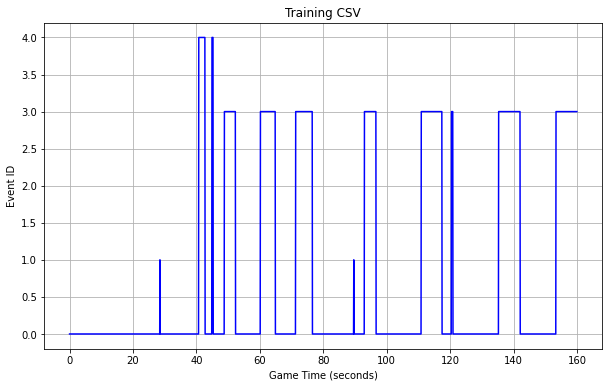

In [4]:
timestamps_training, positions_training = get_filtered_data(path=TRAINING_PATH, starting_row=TRAINING_START_ROW, ending_row=TRAINING_END_ROW)

plt.figure(figsize=(10,6))
plt.plot(timestamps_training, positions_training[:,-1] ,color='blue')
plt.title('Training CSV')
plt.xlabel('Game Time (seconds)')
plt.ylabel('Event ID')
plt.grid()
plt.show()


Now it's needed to get and proccess data accordingly

In [5]:
n_examples = len(positions_training)

n_features = positions_training.shape[1] - 1


# Applying normalization
scaler = MinMaxScaler(feature_range=(0,1)) # Apply values to [0, 1]
positions_training_scaled = scaler.fit_transform(positions_training)

# print(f"{positions_training = }")
# print(f"{positions_training_scaled = }")

# Convert training array to the right shape
features_set = []
labels = []

for i in range(PAST_TIME_STEPS, n_examples):
    features_set.append(positions_training_scaled[i-PAST_TIME_STEPS:i, 0:n_features]) # previous N records
    labels.append(positions_training_scaled[i, -1])

# Converting to numpy arrays
features_set, labels = np.array(features_set), np.array(labels)
# print(features_set)

# Converting to the LSTM format where the dimensions are:
# - number of records
# - number of time steps (past steps)
# - number of indicators/features.
features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], features_set.shape[2]))
print(f"{features_set.shape = }")

features_set.shape = (1940, 60, 69)


Second Try

In [6]:
X_train = positions_training[:,:-1]
Y_train = positions_training[:,-1]
Y_train = Y_train.astype(np.int32)

# Converts to array of ids itself (se calhar n precisa no futuro, usar enquanto aparecem poucos outputs nos labels)
label_encoder = LabelEncoder()
onehot_encoder = OneHotEncoder(sparse=False)

Y_train = label_encoder.fit_transform(Y_train)
Y_train = Y_train.reshape(len(Y_train), 1)
Y_train_onehot = onehot_encoder.fit_transform(Y_train)
n_outputs = len(np.unique(Y_train))



print(Y_train_onehot)


[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


With the data loaded and formatted, now it's time to create the model itself.

In [7]:
# Model initialization
model = Sequential()

# Adding LSTM layer
# a funcao "add" literalmente adiciona um novo layer, que no nosso caso, sera um LSTM

# The fist LSTM parameter is the number of neurons on the node
# The second one is basically true, because we'll add more layers to the model
# The last one is a shape indicating the number of time steps and the number of indicators

model.add(LSTM(units=N_NEURONS_LSTM, return_sequences=True, input_shape=(features_set.shape[1], features_set.shape[2])))
# model.add(LSTM(units=N_NEURONS_LSTM, return_sequences=True))


# Adding Dropout layer (avoids over-fitting)
model.add(Dropout(0.2))

# Adding three more LSTM and Dropout layers
model.add(LSTM(units=N_NEURONS_LSTM, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=N_NEURONS_LSTM, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=N_NEURONS_LSTM))
model.add(Dropout(0.2))

# Adding Dense Layer (ending layer...?)
# 1 unit beause we want to predict
model.add(Dense(n_outputs))


# Compiling the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])


2022-04-23 20:32:17.868093: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-23 20:32:17.868128: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-23 20:32:17.868153: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (itstar-MacBookPro): /proc/driver/nvidia/version does not exist
2022-04-23 20:32:17.868911: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Training the model

In [8]:
# Training the model
# epochs --> number of iteractions probably
history = model.fit(features_set, labels, epochs = 5, batch_size = BATCH_SIZE)

Epoch 1/5


2022-04-23 20:32:22.886268: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 32126400 exceeds 10% of free system memory.


20/20 [==============================] - 19s 299ms/step - loss: 0.1412 - accuracy: 0.2582
Epoch 2/5
20/20 [==============================] - 5s 250ms/step - loss: 0.1175 - accuracy: 0.1304
Epoch 3/5
20/20 [==============================] - 5s 252ms/step - loss: 0.1116 - accuracy: 0.2031
Epoch 4/5
20/20 [==============================] - 6s 292ms/step - loss: 0.1107 - accuracy: 0.2263
Epoch 5/5
20/20 [==============================] - 5s 258ms/step - loss: 0.1093 - accuracy: 0.2361


Plot History

dict_keys(['loss', 'accuracy'])


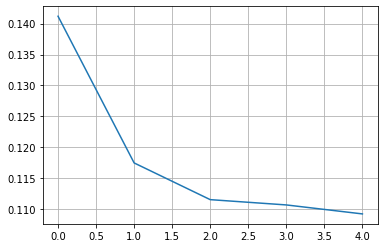

In [12]:
print(history.history.keys())
plt.plot(history.history.get("loss"))
plt.grid()
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

Plotting our test model

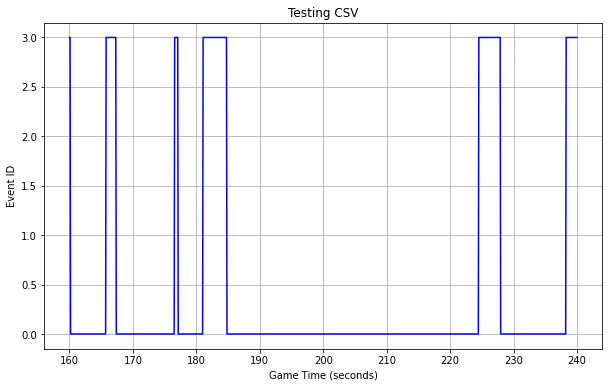

In [9]:
timestamps_testing, positions_testing = get_filtered_data(path=TEST_PATH, starting_row=TEST_START_ROW, ending_row=TEST_END_ROW)

plt.figure(figsize=(10,6))
plt.plot(timestamps_testing, positions_testing[:,-1] ,color='blue')
plt.title('Testing CSV')
plt.xlabel('Game Time (seconds)')
plt.ylabel('Event ID')
plt.grid()
plt.show()


Testing our model

In [10]:
# Reshaping the testing
positions_testing_scaled = scaler.transform(positions_testing)
n_tests = len(positions_testing)

# Add Past time
test_features = []
test_labels = []
for i in range(PAST_TIME_STEPS, n_tests): 
    test_features.append(positions_testing_scaled[i-PAST_TIME_STEPS:i, 0:n_features])
    test_labels.append(positions_testing_scaled[i, -1])


# Convert to the LSTM format
test_features = np.array(test_features)
test_labels = np.array(test_labels)
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], test_features.shape[2]))

test_loss, test_accuracy = model.evaluate(test_features, test_labels, verbose=2)
print(f"{test_loss = }")
print(f"{test_accuracy = }")

training_loss, training_accuracy = model.evaluate(features_set, labels, verbose=2)
print(f"{training_loss = }")
print(f"{training_accuracy = }")



30/30 - 4s - loss: 0.0894 - accuracy: 0.0085 - 4s/epoch - 134ms/step
test_loss = 0.08940611779689789
test_accuracy = 0.008510638028383255
61/61 - 1s - loss: 0.1035 - accuracy: 0.2479 - 1s/epoch - 23ms/step
training_loss = 0.10354796797037125
training_accuracy = 0.2479381412267685


Making Predictions

In [219]:
predictions = model.predict(test_features)
print(f"{predictions.shape = }")
print(f"{predictions[0:2] = }") # probabilidade das 3 classes
print(f"{np.argmax(predictions[0:2])}")
# predictions_dataset_like = np.zeros(shape=(len(predictions), n_features))
# predictions_dataset_like[:,0] = predictions[:,0]
# # inverse transform and then select the right field
# predictions = scaler.inverse_transform(predictions_dataset_like)[:,0]

predictions = scaler.inverse_transform(predictions[:,0]) # reverse the scale
# print(f"{predictions.shape = }")
# print(f"{test_features.shape = }")
# print(f"{n_features = }")



predictions.shape = (940, 3)
predictions[0:2] = array([[0.8011125 , 0.8097504 , 0.7945801 ],
       [0.8013106 , 0.80991447, 0.79474187]], dtype=float32)
4


ValueError: Expected 2D array, got 1D array instead:
array=[0.8011125  0.8013106  0.80150765 0.8017037  0.80189854 0.80209255
 0.80228543 0.8024774  0.8026682  0.8028582  0.803047   0.8032349
 0.8034218  0.8036077  0.80379254 0.8039766  0.8041597  0.80434173
 0.80452293 0.8047032  0.80488235 0.80506074 0.8052381  0.8054146
 0.80559015 0.80576485 0.8059388  0.80611163 0.80628353 0.80645484
 0.80662507 0.8067945  0.806963   0.80713075 0.8072975  0.80746347
 0.80762863 0.80779296 0.8079565  0.8081191  0.80828106 0.80844206
 0.80860215 0.8087616  0.80892026 0.8090781  0.8092351  0.8093913
 0.80954677 0.8097015  0.8098554  0.81000865 0.81016093 0.8103126
 0.81046337 0.8106136  0.81076294 0.8109117  0.81105953 0.8112068
 0.81135327 0.811499   0.811644   0.8117883  0.8119319  0.8120749
 0.8122171  0.8123587  0.81249946 0.81263965 0.8127792  0.81291795
 0.8130562  0.81319344 0.81333023 0.81346637 0.8136019  0.81373674
 0.8138709  0.8140044  0.8141373  0.8142695  0.8144011  0.8145321
 0.8146624  0.8147921  0.8149213  0.8150497  0.81517774 0.81530493
 0.81543165 0.81555766 0.8156831  0.81580806 0.8159324  0.816056
 0.8161792  0.8163017  0.8164237  0.8165452  0.8166658  0.8167862
 0.81690586 0.8170251  0.8171435  0.8172615  0.81737906 0.817496
 0.81761247 0.81772834 0.8178435  0.8179583  0.81807244 0.8181862
 0.8182995  0.81841207 0.8185243  0.8186359  0.81874704 0.8188576
 0.81896776 0.8190774  0.8191864  0.819295   0.8194032  0.81951064
 0.81961775 0.81972456 0.8198307  0.81993634 0.82004154 0.82014614
 0.8202506  0.8203543  0.8204575  0.8205604  0.82066274 0.8207647
 0.82086617 0.82096726 0.82106763 0.82116777 0.8212675  0.8213666
 0.8214653  0.82156366 0.82166165 0.82175916 0.8218562  0.8219527
 0.8220489  0.82214457 0.8222398  0.8223347  0.82242924 0.8225233
 0.822617   0.8227101  0.822803   0.8228956  0.8229875  0.82307917
 0.82317024 0.8232611  0.8233516  0.82344157 0.8235312  0.8236205
 0.8237092  0.8237978  0.82388586 0.8239737  0.82406086 0.8241478
 0.8242344  0.82432073 0.82440645 0.8244919  0.82457703 0.82466173
 0.8247461  0.8248301  0.8249138  0.82499695 0.82508    0.82516253
 0.8252448  0.8253267  0.8254081  0.8254894  0.8255703  0.82565063
 0.82573086 0.8258107  0.82589024 0.8259693  0.8260481  0.8261267
 0.8262048  0.82628256 0.82636005 0.8264372  0.8265142  0.82659066
 0.8266669  0.8267427  0.8268183  0.82689357 0.82696855 0.82704324
 0.82711756 0.82719153 0.8272652  0.82733864 0.82741183 0.82748455
 0.8275571  0.82762927 0.82770115 0.8277728  0.8278441  0.82791513
 0.8279859  0.82805634 0.8281264  0.82819635 0.82826585 0.82833517
 0.82840425 0.8284729  0.82854134 0.8286095  0.8286775  0.82874507
 0.8288123  0.8288795  0.82894623 0.8290128  0.829079   0.8291451
 0.82921076 0.82927626 0.82934135 0.82940644 0.82947105 0.8295354
 0.8295996  0.8296636  0.82972723 0.8297906  0.8298537  0.8299166
 0.8299793  0.8300417  0.8301039  0.8301658  0.83022743 0.8302888
 0.83034986 0.8304109  0.83047146 0.8305319  0.83059216 0.8306521
 0.83071184 0.8307713  0.83083063 0.8308895  0.8309484  0.83100706
 0.83106536 0.83112353 0.83118135 0.831239   0.83129644 0.8313536
 0.8314106  0.8314674  0.83152384 0.8315802  0.83163637 0.8316923
 0.83174783 0.83180326 0.8318585  0.83191353 0.83196837 0.832023
 0.83207744 0.83213156 0.8321855  0.8322393  0.83229285 0.83234614
 0.8323994  0.83245224 0.83250505 0.8325577  0.83261    0.8326621
 0.832714   0.8327658  0.8328173  0.83286864 0.8329199  0.8329708
 0.8330216  0.8330721  0.8331226  0.83317274 0.8332228  0.83327264
 0.8333222  0.83337164 0.83342105 0.8334699  0.83351886 0.83356756
 0.8336162  0.8336646  0.83371264 0.83376074 0.8338086  0.8338561
 0.83390355 0.8339508  0.83399785 0.8340449  0.8340916  0.8341381
 0.8341846  0.8342308  0.83427685 0.83432263 0.83436847 0.83441406
 0.83445936 0.83450466 0.8345496  0.83459455 0.83463925 0.83468384
 0.8347283  0.83477265 0.83481663 0.8348605  0.8349042  0.83494776
 0.8349914  0.83503455 0.83507764 0.8351206  0.8351634  0.8352061
 0.83524865 0.8352909  0.83533317 0.83537513 0.83541703 0.8354587
 0.8355003  0.8355418  0.83558303 0.8356243  0.83566517 0.83570606
 0.83574665 0.83578736 0.8358277  0.83586794 0.8359081  0.83594805
 0.8359878  0.83602756 0.8360671  0.8361065  0.8361458  0.8361848
 0.8362239  0.83626276 0.8363015  0.8363401  0.8363785  0.83641684
 0.8364549  0.83649296 0.8365309  0.8365687  0.8366064  0.8366439
 0.83668125 0.8367184  0.8367557  0.83679265 0.8368295  0.8368662
 0.8369027  0.8369394  0.83697563 0.8370119  0.83704793 0.837084
 0.83711976 0.8371554  0.83719105 0.8372267  0.837262   0.83729726
 0.8373323  0.83736736 0.83740216 0.8374369  0.8374716  0.8375061
 0.83754045 0.8375748  0.83760893 0.83764297 0.83767694 0.8377106
 0.83774453 0.8377779  0.8378114  0.8378449  0.83787805 0.8379113
 0.83794427 0.8379771  0.83800995 0.8380427  0.8380753  0.8381077
 0.8381401  0.8381724  0.8382045  0.83823663 0.8382685  0.83830017
 0.838332   0.83836365 0.8383952  0.83842665 0.8384579  0.83848906
 0.8385201  0.8385512  0.838582   0.83861285 0.83864343 0.838674
 0.83870465 0.8387349  0.8387652  0.83879536 0.8388255  0.83885556
 0.83888537 0.8389152  0.83894485 0.8389744  0.8390041  0.83903337
 0.8390627  0.8390919  0.8391209  0.83914995 0.839179   0.83920777
 0.83923656 0.83926517 0.83929366 0.83932215 0.83935064 0.8393789
 0.839407   0.83943516 0.83946323 0.8394912  0.839519   0.8395466
 0.83957446 0.83960193 0.83962935 0.8396569  0.83968407 0.8397115
 0.8397384  0.83976537 0.83979255 0.8398194  0.8398461  0.8398728
 0.83989936 0.83992606 0.8399525  0.8399789  0.8400052  0.8400313
 0.84005743 0.8400834  0.84010947 0.8401353  0.8401613  0.84018695
 0.8402125  0.84023803 0.84026355 0.84028894 0.8403143  0.8403395
 0.84036475 0.8403898  0.84041494 0.84043974 0.84046453 0.8404894
 0.8405142  0.8405388  0.8405633  0.84058774 0.84061223 0.84063655
 0.8406607  0.840685   0.84070903 0.84073323 0.84075713 0.84078103
 0.84080476 0.84082854 0.8394658  0.8372596  0.83426714 0.8306075
 0.82626253 0.82109493 0.8148918  0.8074098  0.79841995 0.78773195
 0.77520573 0.76075834 0.7443681  0.72607523 0.705974   0.6841959
 0.66089755 0.6362624  0.6105157  0.5839378  0.55686855 0.5296954
 0.50282985 0.4766791  0.45161903 0.4279722  0.40599495 0.3858705
 0.36770934 0.3515535  0.33738458 0.3251337  0.31469193 0.3059214
 0.298665   0.29275554 0.28802368 0.28430378 0.2814388  0.27928364
 0.27770713 0.27659318 0.2758409  0.2753644  0.27509144 0.27496278
 0.27493036 0.27495608 0.2750105  0.2750711  0.2751217  0.27515084
 0.27515155 0.2751207  0.27505887 0.27496976 0.2748571  0.27471426
 0.27450502 0.27415827 0.2742493  0.27433994 0.27443033 0.2745204
 0.27461016 0.2746997  0.27478895 0.27487803 0.27496684 0.27505547
 0.27514386 0.27523214 0.2753202  0.27540815 0.27549598 0.27558362
 0.2756712  0.2757586  0.2758459  0.27593315 0.2760203  0.2761074
 0.27619442 0.2762814  0.2763683  0.27645513 0.27654198 0.27662876
 0.27671558 0.27680233 0.27688906 0.27697578 0.2770625  0.27714923
 0.277236   0.27732277 0.27740955 0.2774964  0.27758318 0.27767012
 0.27775702 0.27784392 0.27793095 0.27801797 0.27810505 0.2781922
 0.27827942 0.27836666 0.27845392 0.27854133 0.27862877 0.27871627
 0.27880388 0.27889153 0.27897927 0.27906707 0.27915502 0.279243
 0.27933106 0.27941915 0.27950746 0.2795958  0.27968425 0.27977273
 0.2798614  0.27995008 0.2800389  0.28012782 0.28021684 0.28030595
 0.28039515 0.2804844  0.28057393 0.28066346 0.28075308 0.28084284
 0.28093272 0.28102267 0.28111273 0.28120294 0.28129324 0.28138366
 0.28147417 0.28156486 0.28165558 0.28174648 0.28183746 0.28192857
 0.28201976 0.28211114 0.28220254 0.28229415 0.2823858  0.28247765
 0.28256962 0.28266165 0.28275377 0.28284612 0.2829385  0.28303108
 0.28312373 0.2832165  0.28330943 0.2834024  0.28349552 0.28358877
 0.2836822  0.28377572 0.28386933 0.2839631  0.28405693 0.284151
 0.28424504 0.2843393  0.28443372 0.28452817 0.2846228  0.28471756
 0.2848124  0.2849074  0.2850025  0.2850977  0.2851931  0.28528848
 0.28538412 0.28547984 0.2855757  0.28567162 0.2857677  0.28586394
 0.2859603  0.28605673 0.28615326 0.28624997 0.28634676 0.28644374
 0.28654072 0.28663793 0.28673524 0.28683263 0.28693014 0.2870278
 0.2871256  0.28722352 0.2873215  0.28741965 0.2875179  0.28761628
 0.28771475 0.28781334 0.28791207 0.28801095 0.2881099  0.28820896
 0.28830814 0.28840744 0.28850693 0.28860646 0.2887061  0.28880584
 0.28890577 0.2890058  0.2891059  0.28920612 0.28930646 0.28940693
 0.2895075  0.28960818 0.28970894 0.2898099  0.2899109  0.29001197
 0.29011327 0.2902146  0.29031613 0.29041764 0.29051936 0.29062116
 0.29072306 0.29082507 0.2909272  0.29102945 0.29113173 0.29123414
 0.29133675 0.29143938 0.29154214 0.29164502 0.291748   0.29185107
 0.29195425 0.29205754 0.29216093 0.2922644  0.29236802 0.29247168
 0.2925755  0.2926794  0.2927834  0.2928875  0.2929917  0.29309604
 0.29320037 0.2933049  0.2934095  0.29351416 0.29361898 0.29372385
 0.29382882 0.29393393 0.29403907 0.29414436 0.29424968 0.29435515
 0.2944607  0.29456636 0.2946721  0.29477793 0.29488382 0.2949898
 0.29509592 0.29520214 0.2953084  0.29541475 0.2955212  0.29562774
 0.29573435 0.29584107 0.29594788 0.29605475 0.2961617  0.29626876
 0.2963759  0.29648313 0.2965904  0.29669783 0.29680523 0.29691282
 0.29702044 0.29712817 0.29723597 0.2973438  0.29745167 0.29755968
 0.29766783 0.29777592 0.2978842  0.29799253 0.29810092 0.29820937
 0.29831794 0.2984265  0.29853526 0.29864398 0.2987528  0.29886165
 0.2989706  0.29907966 0.29918876 0.29929796 0.2994072  0.29951644
 0.2996258  0.29973525 0.29984474 0.29995424 0.3000639  0.30017358
 0.3002833  0.30039304 0.30050296 0.30061287 0.30072284 0.30083287
 0.30094296 0.3010531  0.3011633  0.30127352 0.3013838  0.3014942
 0.30160463 0.3017151  0.30182558 0.30193618 0.3020468  0.30215743
 0.30226815 0.30237895 0.3024897  0.30260056 0.3027115  0.3028224
 0.3029334  0.30304438 0.30315545 0.30326658 0.30337772 0.3034889
 0.30360013 0.30371138 0.30382267 0.30393404 0.30404538 0.30415678
 0.30426824 0.3043797  0.30449125 0.30460274 0.30471432 0.30482593
 0.30493757 0.3050492  0.30516088 0.30527258 0.3053843  0.30549604
 0.30560786 0.30571967 0.3058315  0.30594334 0.3060552  0.30616707
 0.3062789  0.3063909  0.30650288 0.3066148  0.30672675 0.30683872
 0.30695075 0.30706275 0.3071748  0.30728683 0.3073988  0.30751088
 0.30762294 0.30773503 0.30784714 0.30795917 0.30807126 0.3081833
 0.30829543 0.30840752 0.3085196  0.30863166 0.30874377 0.30885583
 0.3089679  0.30908    0.30919203 0.30930412].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

Plot results

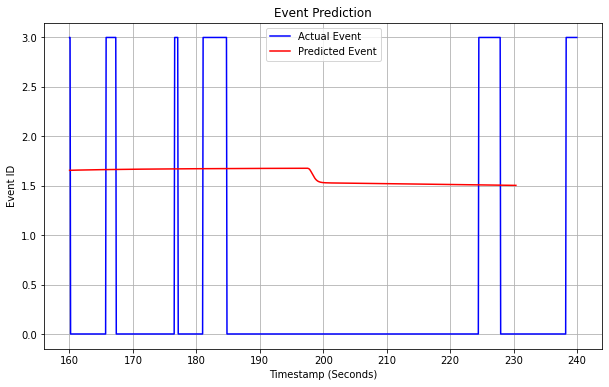

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(timestamps_testing, positions_testing[:,-1], color='blue', label='Actual Event')
plt.plot(timestamps_testing[:-PAST_TIME_STEPS], predictions[:,-1] , color='red', label='Predicted Event')
plt.title('Event Prediction')
plt.xlabel('Timestamp (Seconds)')
plt.ylabel('Event ID')
plt.legend()
plt.grid()
plt.show()